In [1]:
# Import necessary modules
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import subprocess
import matplotlib.pyplot as plt

In [2]:
# Define the path to your shapefile
shapefile_path = '/Users/macbokpro/Desktop/vessels at anchorage state/anchorage area/AnchorageAreas.shp'

# Read the shapefile
anchorage = gpd.read_file(shapefile_path)
anchorage = anchorage.to_crs(epsg=4326)  # Ensure CRS is compatible

# Print the first few rows to see the data
print(anchorage.head())

# Check the geometry type of each feature
geometry_types = anchorage.geom_type
print("Geometry types in the shapefile:")
print(geometry_types.value_counts())

# Print the unique geometry types
unique_geometry_types = anchorage.geom_type.unique()
print(f"Unique geometry types: {unique_geometry_types}")

# Verify if all geometries are of a specific type
if all(anchorage.geom_type == 'Polygon'):
    print("All geometries are polygons.")
elif all(anchorage.geom_type == 'LineString'):
    print("All geometries are lines.")
elif all(anchorage.geom_type == 'Point'):
    print("All geometries are points.")
else:
    print("The shapefile contains mixed geometry types.")


     INSIDE_X   INSIDE_Y     CENTROID_X     CENTROID_Y   Shape_Leng  \
0 -118.177132  33.751509  211612.861827 -351138.116846  1748.494224   
1 -118.170730  33.749480  212202.386518 -351343.456828  1902.221417   
2 -118.164030  33.747685  212818.406691 -351522.301446  1755.908367   
3 -118.178010  33.745121  211553.246964 -351840.247355  2041.029997   
4 -118.170072  33.743356  212281.872973 -352012.468055  2372.649177   

      Shape_Area                                           geometry  
0  243286.796614  POLYGON Z ((-118.17715 33.74897 0, -118.17731 ...  
1  287946.809135  POLYGON Z ((-118.17024 33.74675 0, -118.17041 ...  
2  245354.389789  POLYGON Z ((-118.16441 33.74515 0, -118.16457 ...  
3  331504.105302  POLYGON Z ((-118.17687 33.74231 0, -118.17704 ...  
4  447978.520678  POLYGON Z ((-118.17027 33.73991 0, -118.17045 ...  
Geometry types in the shapefile:
Polygon    81
Name: count, dtype: int64
Unique geometry types: ['Polygon']
All geometries are polygons.


In [8]:
# Function to process each CSV file and return daily counts of unique vessels
def process_csv(input_file):
    # Read input CSV file as a pandas dataframe with low memory option to handle mixed data types
    df = pd.read_csv(input_file, on_bad_lines='skip', low_memory=False)

    # Check the initial DataFrame
    print(f"Initial DataFrame head for {input_file}:")
    print(df.head())
    print(f"Initial DataFrame shape for {input_file}:", df.shape)
    
    # Check for the expected columns
    expected_columns = ['LON', 'LAT', 'BaseDateTime', 'SOG', 'MMSI']
    for col in expected_columns:
        if col not in df.columns:
            print(f"Warning: Column {col} not found in {input_file}")
            return pd.Series(dtype=int)  # Return an empty series if any expected column is missing
    
    # Convert dataframe to geodataframe using LAT and LON fields
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT, crs="EPSG:4326"))

    # Intersect AIS points with anchorage area
    gdf = gpd.sjoin(gdf, anchorage, how="inner", predicate='within')

    # Check the result of the spatial join
    print(f"GeoDataFrame after spatial join head for {input_file}:")
    print(gdf.head())
    print(f"GeoDataFrame after spatial join shape for {input_file}:", gdf.shape)

    if gdf.empty:
        print(f"No points within the anchorage area for {input_file}. Check the input data and the anchorage area shapefile.")
        return pd.Series(dtype=int)  # Return an empty series

    # Filter vessels at anchorage state (SOG < 1)
    anchorage_vessels = gdf[gdf['SOG'] < 1]

    # Convert BaseDateTime to datetime and create a 'date' column
    anchorage_vessels['BaseDateTi'] = pd.to_datetime(anchorage_vessels['BaseDateTime'])
    anchorage_vessels['date'] = anchorage_vessels['BaseDateTi'].dt.date
    daily_counts = anchorage_vessels.groupby('date')['MMSI'].nunique()

    return daily_counts

In [4]:
# # Function to process each CSV file and return daily counts of unique vessels
# def process_csv(input_file):
#     # Read input CSV file as a pandas dataframe with low memory option to handle mixed data types
#     df = pd.read_csv(input_file, on_bad_lines='skip', low_memory=False)

#     # Check the initial DataFrame
#     print(f"Initial DataFrame head for {input_file}:")
#     print(df.head())
#     print(f"Initial DataFrame shape for {input_file}:", df.shape)

#     # Convert dataframe to geodataframe using LAT and LON fields
#     gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT, crs="EPSG:4326"))

#     # Intersect AIS points with anchorage area
#     gdf = gpd.sjoin(gdf, anchorage, how="inner", predicate='within')

#     # Check the result of the spatial join
#     print(f"GeoDataFrame after spatial join head for {input_file}:")
#     print(gdf.head())
#     print(f"GeoDataFrame after spatial join shape for {input_file}:", gdf.shape)

#     if gdf.empty:
#         print(f"No points within the anchorage area for {input_file}. Check the input data and the anchorage area shapefile.")
#         return pd.Series(dtype=int)  # Return an empty series

#     # Filter vessels at anchorage state (SOG < 1)
#     anchorage_vessels = gdf[gdf['SOG'] < 1]

#     # Count the number of unique vessels at anchorage state for each day
#     anchorage_vessels['BaseDateTi'] = pd.to_datetime(anchorage_vessels['BaseDateTi'])
#     anchorage_vessels['date'] = anchorage_vessels['BaseDateTi'].dt.date
#     daily_counts = anchorage_vessels.groupby('date')['MMSI'].nunique()

#     return daily_counts


In [ ]:
# # List of input CSV files for each month of 2020
# input_files = [f'/Users/macbokpro/Desktop/AIS/AIS_2020_{str(i).zfill(2)}.csv' for i in range(1, 13)]

# # Step 1: Process each CSV file and combine results
# combined_daily_counts = pd.DataFrame()

#     monthly_counts = process_csv(input_file)
#     combined_daily_counts = pd.concat([combined_daily_counts, monthly_counts], axis=1)

# # Combine the results, ensuring we have proper columns for each month
# combined_daily_counts.columns = [f'Month_{str(i).zfill(2)}' for i in range(1, 13)]
# combined_daily_counts = combined_daily_counts.fillna(0)  # Fill NaN with 0

In [9]:
# Generate list of input CSV files for each month from January 2020 to June 2022
input_files = [f'/Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_{year}_{str(month).zfill(2)}.csv' 
               for year in range(2020, 2023) 
               for month in range(1, 13) if not (year == 2022 and month > 6)]

In [10]:
# Step 1: Process each CSV file and combine results
combined_daily_counts = pd.DataFrame()

for input_file in input_files:
    monthly_counts = process_csv(input_file)
    combined_daily_counts = pd.concat([combined_daily_counts, monthly_counts], axis=1)

Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_01.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368064650  2020-01-01T00:00:00  33.72365 -118.27967   0.0  360.0    511.0   
1    3669999  2020-01-01T00:00:01  33.72340 -118.28068   0.1  258.5    511.0   
2  367661930  2020-01-01T00:00:02  33.72981 -118.27564   0.1  301.7    511.0   
3  368024740  2020-01-01T00:00:03  33.72909 -118.18749  16.7   85.0     81.0   
4  248951000  2020-01-01T00:00:03  33.68217 -118.20249   9.3  198.7    201.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
1             NaN         NaN      NaN         NaN     0.0     NaN    NaN   
2  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
3             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
4             NaN         Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_02.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338344191  2020-01-29T00:00:00  33.97608 -118.44849  3.6  353.5    511.0   
1  338926430  2020-01-29T00:00:00  33.72486 -118.26920  0.2    0.0    342.0   
2  368019930  2020-01-29T00:00:00  34.14771 -119.20300  0.0  292.2    269.0   
3  374602000  2020-01-29T00:00:01  33.75258 -118.23147  1.1    2.5     51.0   
4  367689990  2020-01-29T00:00:01  33.73424 -118.27731  0.0  276.4    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0       MARIAH  NaN      NaN        36.0     NaN    11.0    6.0    NaN    NaN   
1          NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2          NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3          NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4  HARBOR KING

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_03.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  338327877  2020-03-01T00:00:01  33.68351 -118.24362   4.2  169.7    511.0   
1  319122900  2020-03-01T00:00:02  33.97917 -118.44532   0.0   90.1    511.0   
2  319157700  2020-03-01T00:00:02  33.60848 -117.91261   4.3  264.0    254.0   
3  367001740  2020-03-01T00:00:02  33.34448 -118.32206   0.0  201.2    159.0   
4  368014440  2020-03-01T00:00:02  33.70164 -118.23043  12.6  293.4    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0           JASON  NaN      NaN        36.0     NaN     5.0    0.0    NaN   
1         FIREFLY  NaN      NaN        37.0     NaN    22.0    6.0    NaN   
2             NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN   
3  CATALINA FLYER  NaN  WTD8887        60.0     0.0    34.0   11.0    NaN   
4             NaN  NaN      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_04.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  367303000  2020-04-02T00:00:00  33.75165 -118.17904   0.0  360.0    182.0   
1  368064650  2020-04-02T00:00:01  33.72372 -118.27963   0.0  360.0    511.0   
2  368019930  2020-04-02T00:00:01  34.14771 -119.20300   0.0    5.0    271.0   
3  338131199  2020-04-02T00:00:01  33.75585 -118.11642   0.0    0.0    511.0   
4  636019100  2020-04-02T00:00:02  33.93093 -118.95862  11.6  297.0    297.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_05.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368084540  2020-05-01T00:00:00  33.72575 -118.19221   0.5  137.5    157.0   
1  374858000  2020-05-01T00:00:04  33.69012 -118.18046  10.5  354.3    355.0   
2  241531000  2020-05-01T00:00:06  33.67821 -118.12270   0.1  268.5    233.0   
3  368064650  2020-05-01T00:00:06  33.72372 -118.27960   0.1   55.5    511.0   
4  367422010  2020-05-01T00:00:07  33.75398 -118.22398   0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_06.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368024740  2020-05-31T00:00:01  33.70405 -118.16718  20.5  329.4    328.0   
1    3669999  2020-05-31T00:00:01  33.72340 -118.28066   0.0  256.8    511.0   
2  366892000  2020-05-31T00:00:01  33.63747 -118.14087   3.3  279.8    290.0   
3  366675760  2020-05-31T00:00:02  33.97285 -118.45349   0.0  273.9    511.0   
4  368136950  2020-05-31T00:00:03  33.64275 -118.14263  10.9  156.5    163.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0           NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN   
1           NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN   
2           NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN   
3  ANTICIPATION  NaN  WCR4950        37.0     0.0    23.0    6.0    NaN   
4           NaN  NaN      NaN         

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_07.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338131199  2020-07-02T00:00:00  33.75586 -118.11638  0.0   43.7    511.0   
1  366872980  2020-07-02T00:00:00  33.61827 -117.92222  0.0  360.0    511.0   
2  366983530  2020-07-02T00:00:00  33.75538 -118.22905  0.2  355.3    266.0   
3  338155803  2020-07-02T00:00:00  33.71989 -118.43067  6.4  350.8    511.0   
4  368019930  2020-07-02T00:00:00  34.14774 -119.20301  0.0  139.0    271.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
1  ENDLESS DREAMS  IMO8975677  WDH2906        60.0     0.0    41.0    9.0   
2      JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0   
3             NaN         NaN      NaN         NaN     0.0     NaN    NaN   
4             NaN         NaN     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_08.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368136950  2020-07-31T00:00:00  33.75950 -118.21362  0.0   77.8     89.0   
1  636017537  2020-07-31T00:00:00  33.75180 -118.24048  0.0  232.9    251.0   
2    3669999  2020-07-31T00:00:00  33.72341 -118.28062  0.0  242.4    511.0   
3  338131199  2020-07-31T00:00:00  33.75583 -118.11641  0.0    9.0    511.0   
4  368019930  2020-07-31T00:00:00  34.14823 -119.20509  0.0  324.8    190.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_09.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367719100  2020-09-01T00:00:00  33.76924 -118.22231  2.7  186.4    180.0   
1  366892000  2020-09-01T00:00:00  33.72816 -118.19344  8.0  262.4    265.0   
2  367422010  2020-09-01T00:00:00  33.77561 -118.24512  0.0  360.0    511.0   
3  368084540  2020-09-01T00:00:00  33.74235 -118.21529  7.8  346.2    340.0   
4  367303000  2020-09-01T00:00:01  33.75600 -118.21443  0.0  360.0    357.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_10.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367719100  2020-10-01T00:00:00  33.72974 -118.27585  0.6  258.3     68.0   
1  367303000  2020-10-01T00:00:00  33.74472 -118.21589  5.9  333.8    329.0   
2  368084540  2020-10-01T00:00:00  33.74026 -118.27811  0.0  254.8      7.0   
3    3669999  2020-10-01T00:00:00  33.72344 -118.28068  0.0  232.9    511.0   
4  367422010  2020-10-01T00:00:00  33.77559 -118.24507  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_11.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368024740  2020-11-02T00:00:00  33.73088 -118.18865  1.2   78.7    302.0   
1  367693690  2020-11-02T00:00:00  33.77170 -118.21191  0.0  321.5    157.0   
2  367401220  2020-11-02T00:00:01  33.76132 -118.19242  0.0  360.0    511.0   
3  368084540  2020-11-02T00:00:01  33.75656 -118.27445  6.6  331.1    328.0   
4  367375360  2020-11-02T00:00:04  34.24178 -119.26436  0.0  261.3    260.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0        NaN         NaN      NaN         NaN    15.0     NaN    NaN    NaN   
1    KELLY C  IMO7035327  WDI3956        31.0     0.0    26.0    8.0    3.6   
2        NaN         NaN      NaN         NaN     0.0     NaN    NaN    NaN   
3        NaN         NaN      NaN         NaN     0.0     NaN    NaN    NaN   
4        NaN         NaN

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2020_12.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368159190  2020-12-01T00:00:00  33.74640 -118.21616   3.9  340.7    511.0   
1  368057770  2020-12-01T00:00:01  33.76551 -118.25524   0.0  219.4    511.0   
2  368072680  2020-12-01T00:00:01  33.97931 -118.45132  65.0  202.7    267.0   
3  338312034  2020-12-01T00:00:01  33.97310 -118.45005   0.0  360.0    511.0   
4  338926432  2020-12-01T00:00:02  33.72610 -118.26964   0.0   22.2    344.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0             NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN   
1  LAFD FAST BOAT  NaN  WDK4691        51.0     NaN     9.0    3.0    NaN   
2             NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN   
3       MIRABELLA  NaN      NaN        37.0     NaN    12.0    5.0    NaN   
4             NaN  NaN      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_01.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367719100  2021-01-02T00:00:00  33.72976 -118.27565  0.1  256.6    309.0   
1  368064650  2021-01-02T00:00:00  33.72369 -118.27978  0.0  360.0    511.0   
2  368072680  2021-01-02T00:00:00  33.98313 -118.44806  0.1  253.9    270.0   
3  367303000  2021-01-02T00:00:00  33.72844 -118.16408  0.1  360.0    255.0   
4  368024740  2021-01-02T00:00:00  33.74722 -118.21566  0.0   81.6    103.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_02.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368024740  2021-01-31T00:00:00  33.71702 -118.18453   5.4  185.2    182.0   
1  367719100  2021-01-31T00:00:01  33.72978 -118.27567   0.0  214.7    306.0   
2  338926978  2021-01-31T00:00:01  33.40664 -118.30639  33.5  172.4    511.0   
3  368072680  2021-01-31T00:00:01  33.98269 -118.44963   0.0  205.9    269.0   
4  311000748  2021-01-31T00:00:02  33.18184 -117.86189   0.5  136.3    217.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_03.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  255806338  2021-03-01T00:00:00  33.75281 -118.27431   0.0  169.1    329.0   
1  368024590  2021-03-01T00:00:01  33.72403 -118.28088   0.0  345.6    511.0   
2  338926430  2021-03-01T00:00:01  33.49605 -118.12009  28.4  339.7    340.0   
3  367303000  2021-03-01T00:00:02  33.77640 -118.21065   0.0  360.0    242.0   
4  368171260  2021-03-01T00:00:02  33.73386 -118.27384   0.5   55.7     69.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0               NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN   
1  BOTTOM SCRATCHER  NaN  WDJ9293        34.0     NaN    21.0    6.0    NaN   
2               NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN   
3               NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN   
4               Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_04.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338300185  2021-04-02T00:00:05  33.35699 -118.21277  6.4  263.9    511.0   
1  368167990  2021-04-02T00:00:07  33.61021 -117.92526  0.0  112.4    511.0   
2  338069896  2021-04-02T00:00:07  34.16334 -119.22595  0.0  141.7    511.0   
3  338068521  2021-04-02T00:00:14  33.98194 -118.44886  0.0  329.6    511.0   
4  338336818  2021-04-02T00:00:15  33.61143 -117.92679  0.0  252.0    511.0   

        VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0            ILEAN  NaN    ILEAN        36.0     NaN    13.0    4.0    NaN   
1    IT'S ALL GOOD  NaN  WDL8279        37.0     NaN    14.0    5.0    NaN   
2            LOVIT  NaN  WBD4110        37.0     NaN    17.0    5.0    NaN   
3  GOOD VIBRATIONS  NaN      NaN        37.0     NaN    14.0    5.0    NaN   
4       ISLAND FOX  NaN      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_05.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  338386064  2021-05-01T00:00:01  33.75087 -118.11133   0.0  360.0    511.0   
1  338316935  2021-05-01T00:00:03  33.43410 -118.23993  11.2   60.9    511.0   
2  338191476  2021-05-01T00:00:07  33.21040 -117.39575   0.0  360.0    511.0   
3  338369901  2021-05-01T00:00:10  33.60767 -117.91665   0.0  360.0      9.0   
4  338304692  2021-05-01T00:00:12  33.84109 -118.41181   4.8  162.0    511.0   

        VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   THE SALTY BARN  NaN      NaN        37.0     NaN    13.0    4.0    NaN   
1         MOVIN UP  NaN      NaN        37.0     NaN    11.0    4.0    NaN   
2  PERFECT PARTNER  NaN      NaN        37.0     NaN    14.0    4.0    NaN   
3            DOLLY  NaN      NaN        37.0     NaN    18.0    6.0    NaN   
4      SECOND WIND  NaN

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_06.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338393843  2021-06-02T00:00:00  33.71998 -118.28189  0.1   68.1    511.0   
1  338326507  2021-06-02T00:00:01  33.75948 -118.19865  6.4  115.2    511.0   
2  338228367  2021-06-02T00:00:01  33.71796 -118.27784  0.0  223.7    511.0   
3  338145691  2021-06-02T00:00:03  33.97114 -118.44660  0.0  181.6      1.0   
4  983105676  2021-06-02T00:00:11  33.73961 -118.14680  9.3  114.2    511.0   

          VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0          WINE KNOT  NaN      NaN        37.0     NaN    12.0    4.0    NaN   
1          INCOGNITO  NaN      NaN        37.0     NaN     0.0    0.0    NaN   
2         MY REVENGE  NaN      NaN        37.0     NaN    19.0    7.0    NaN   
3        BAYWATCH 12  NaN      NaN        90.0    15.0     9.0    NaN    NaN   
4  RUBY PRINCESS T2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_07.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368006720  2021-06-30T00:00:02  34.09212 -119.26393  5.0   25.1     11.0   
1  368021110  2021-06-30T00:00:03  33.63970 -118.30967  6.8   55.0    511.0   
2  366998840  2021-06-30T00:00:05  33.75285 -118.22050  0.0  178.6    254.0   
3  236000990  2021-06-30T00:00:07  33.61153 -117.92699  0.0    0.0    511.0   
4  338391906  2021-06-30T00:00:07  33.75415 -118.11456  0.0  360.0    511.0   

            VesselName         IMO CallSign  VesselType  Status  Length  \
0         KEY LIME PIE         NaN  WDJ7441        36.0     NaN    13.0   
1         SOME TUESDAY         NaN  WDJ8919        36.0     NaN    15.0   
2  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
3                 TATU         NaN    ZDEU2        37.0     NaN    28.0   
4        NO OFF BUTTON         NaN      NaN 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_08.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368212610  2021-08-04T01:23:53  33.46105 -117.70288  3.2  102.4    511.0   
1  368212610  2021-08-04T19:20:22  33.46106 -117.70288  5.8  283.8    511.0   
2  368121980  2021-08-05T20:53:24  33.45947 -117.69547  2.7  273.5    511.0   
3  366892470  2021-08-02T16:27:15  33.45937 -117.69343  0.1  360.0     86.0   
4  366892470  2021-08-02T23:14:28  33.45936 -117.69342  0.1  360.0    106.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     FREE REIN  NaN  WDM5106        37.0     NaN    18.0    5.0    NaN   
1     FREE REIN  NaN  WDM5106        37.0     NaN    18.0    5.0    NaN   
2     MOONLIGHT  NaN      NaN        37.0     NaN     0.0    0.0    NaN   
3  SHARED DREAM  NaN  WDB3892        37.0     NaN    13.0    5.0    NaN   
4  SHARED DREAM  NaN  WDB3892        37.0   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_09.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368064650  2021-09-01T17:46:25  33.72370 -118.27968  0.0  360.0    511.0   
1  368064650  2021-09-01T17:51:15  33.72370 -118.27966  0.0  360.0    511.0   
2  368064650  2021-09-01T17:58:15  33.72373 -118.27967  0.0  360.0    511.0   
3  368064650  2021-09-01T18:02:24  33.72370 -118.27968  0.1   91.4    511.0   
4  368064650  2021-09-01T18:05:55  33.72371 -118.27967  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   KIN SHIP  NaN  WDK5421        37.0    15.0    26.0    6.0    0.0   37.0   
1   KIN SHIP  NaN  WDK5421        37.0    15.0    26.0    6.0    0.0   37.0   
2   KIN SHIP  NaN  WDK5421        37.0    15.0    26.0    6.0    0.0   37.0   
3   KIN SHIP  NaN  WDK5421        37.0    15.0    26.0    6.0    0.0   37.0   
4   KIN SHIP  NaN  WDK54

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_10.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338320694  2021-09-30T19:36:34  33.97550 -118.44947  0.1    3.4    511.0   
1  338320694  2021-09-30T23:06:34  33.97550 -118.44948  0.0    3.4    511.0   
2  338330108  2021-09-30T18:53:10  33.97564 -118.44948  0.1  290.0    511.0   
3  338330108  2021-09-30T18:56:10  33.97563 -118.44948  0.0  290.0    511.0   
4  338330108  2021-09-30T20:29:12  33.97564 -118.44947  0.0  290.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   ADELANTE  NaN      NaN        36.0     NaN    20.0    5.0    NaN    NaN   
1   ADELANTE  NaN      NaN        36.0     NaN    20.0    5.0    NaN    NaN   
2    MAGARI!  NaN      NaN        36.0     NaN     0.0    0.0    NaN    NaN   
3    MAGARI!  NaN      NaN        36.0     NaN     0.0    0.0    NaN    NaN   
4    MAGARI!  NaN      N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_11.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368120490  2021-11-04T21:23:17  33.61428 -117.92425  3.5  328.9    511.0   
1  338351674  2021-11-04T01:56:55  34.24357 -119.26240  0.0  249.1    511.0   
2  338351674  2021-11-04T02:02:56  34.24357 -119.26239  0.0  249.1    511.0   
3  338351674  2021-11-04T02:05:56  34.24357 -119.26239  0.0  249.1    511.0   
4  338351674  2021-11-04T02:08:57  34.24357 -119.26239  0.0  249.1    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      CAROUSEL  NaN  WDL3319        37.0     NaN    20.0    8.0    NaN   
1  OCTAVIA (US)  NaN      NaN        37.0     NaN    16.0    8.0    NaN   
2  OCTAVIA (US)  NaN      NaN        37.0     NaN    16.0    8.0    NaN   
3  OCTAVIA (US)  NaN      NaN        37.0     NaN    16.0    8.0    NaN   
4  OCTAVIA (US)  NaN      NaN        37.0   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2021_12.csv:
        MMSI         BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338032241  2021-12-03T18:15:23  33.98086 -118.44916  0.0  65.9    511.0   
1  338032241  2021-12-03T18:42:24  33.98087 -118.44916  0.0  65.9    511.0   
2  338032241  2021-12-03T18:45:23  33.98087 -118.44915  0.0  65.9    511.0   
3  338032241  2021-12-03T18:51:23  33.98087 -118.44916  0.0  65.9    511.0   
4  338032241  2021-12-03T18:54:23  33.98087 -118.44916  0.0  65.9    511.0   

            VesselName  IMO CallSign  VesselType  Status  Length  Width  \
0  JUS' PUCKIN' AROUND  NaN      NaN        37.0     NaN    15.0    5.0   
1  JUS' PUCKIN' AROUND  NaN      NaN        37.0     NaN    15.0    5.0   
2  JUS' PUCKIN' AROUND  NaN      NaN        37.0     NaN    15.0    5.0   
3  JUS' PUCKIN' AROUND  NaN      NaN        37.0     NaN    15.0    5.0   
4  JUS' PUCKIN' AROUND  NaN      NaN        37.0  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2022_01.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338392066  2022-01-01T00:00:00  33.84612 -118.39692  0.0  360.0    511.0   
1  338224785  2022-01-01T00:00:01  33.97220 -118.45330  0.0   64.8    511.0   
2  338347484  2022-01-01T00:00:09  33.46101 -117.69138  0.0  360.0    511.0   
3  368224770  2022-01-01T00:00:11  33.73373 -118.26571  0.0  360.0    511.0   
4  367670680  2022-01-01T00:00:13  33.72155 -118.27917  0.0  360.0    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MY BLUE HEAVEN  NaN      NaN        37.0     NaN     9.0    3.0    NaN   
1     CITY LIGHTS  NaN      NaN        37.0     NaN     0.0    0.0    NaN   
2           LYDIE  NaN      NaN        37.0     NaN    15.0    0.0    NaN   
3     NEW HORIZON  NaN  WDM6383        30.0     NaN    26.0    6.0    NaN   
4        ZEPHYRUS  NaN  WDH9696   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2022_02.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368166370  2022-02-02T00:00:00  34.17399 -119.22836   0.0  131.9    511.0   
1  338345406  2022-02-02T00:00:01  34.24769 -119.26560   0.1  360.0    511.0   
2  338382691  2022-02-02T00:00:04  33.97899 -118.44438   0.0  177.8    511.0   
3  338422171  2022-02-02T00:00:08  33.58243 -117.88148  26.0   33.4    511.0   
4  338224484  2022-02-02T00:00:11  33.21088 -117.39715   0.0    0.0    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  LIFE AQUATIC  NaN  WDL8099        37.0     NaN    25.0    6.0    NaN   
1  S/V SURPRISE  NaN      NaN        36.0     NaN    12.0    4.0    NaN   
2       PIRANHA  NaN      NaN        37.0     NaN    19.0    6.0    NaN   
3        SUENOS  NaN      NaN        37.0     NaN    12.0    4.0    NaN   
4         PEARL  NaN      NaN        3

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2022_03.csv:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  338321972  2022-02-28T00:00:01  33.61179 -117.92816   0.0  238.3    511.0   
1  367113620  2022-02-28T00:00:01  33.73888 -118.20699  10.4  320.3    511.0   
2  338397757  2022-02-28T00:00:03  33.97622 -118.44267   0.0  360.0    511.0   
3  338382691  2022-02-28T00:00:05  33.97898 -118.44439   0.0  311.2    511.0   
4  338383211  2022-02-28T00:00:05  33.97522 -118.44756   4.9    2.5    358.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0       PALLADIO  NaN      NaN        37.0     NaN    11.0    4.0    NaN   
1         SPIRIT  NaN  WDD2309        69.0     0.0    30.0    0.0    0.0   
2      FISHIZZLE  NaN      NaN        37.0     NaN    14.0    4.0    NaN   
3        PIRANHA  NaN      NaN        37.0     NaN    19.0    6.0    NaN   
4  ARIES VOYAGER  NaN      NaN   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2022_04.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338179266  2022-04-01T00:00:11  33.61285 -117.90639  3.9  198.2    511.0   
1  338402152  2022-04-01T00:00:13  33.42639 -118.05057  5.3  322.7    319.0   
2  338175175  2022-04-01T00:00:23  34.17919 -119.22695  0.0  360.0    511.0   
3  367751940  2022-04-01T00:00:28  33.60810 -117.92226  0.0  360.0    511.0   
4  367766860  2022-04-01T00:00:37  33.77200 -118.20925  0.0  173.1    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0         INXS  NaN      NaN        37.0     NaN    16.0    5.0    NaN    NaN   
1        AKAW!  NaN  WDM7376        36.0     NaN    12.0    3.0    NaN    NaN   
2  ISLANDIA II  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
3      JAMMIN'  NaN  WDI9765        37.0     NaN    13.0    7.0    NaN    NaN   
4      SEANA C

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2022_05.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338394316  2022-05-03T00:00:01  33.42130 -118.51035  7.8  226.4    511.0   
1  338081579  2022-05-03T00:00:03  33.72086 -118.28048  0.0   58.0    511.0   
2  338396764  2022-05-03T00:00:03  33.34785 -118.32529  0.1  360.0    511.0   
3  338350423  2022-05-03T00:00:13  33.61013 -117.89581  0.0  360.0    511.0   
4  338425335  2022-05-03T00:00:17  33.61478 -117.92368  0.0  360.0    511.0   

          VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0           MANU KAI  NaN      NaN        37.0     NaN    14.0   14.0    NaN   
1             MALIKA  NaN      NaN        37.0     NaN    13.0    4.0    NaN   
2  ONE FISH TWO FISH  NaN      NaN        37.0     NaN    17.0    4.0    NaN   
3      WATER BUFFALO  NaN      NaN        37.0     NaN    12.0   22.0    NaN   
4           WISE GU

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial DataFrame head for /Users/macbokpro/Desktop/vessels at anchorage state/AIS data//AIS_2022_06.csv:
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338186376  2022-06-01T00:00:00  33.45818 -117.69661  0.0  235.7    511.0   
1  338410617  2022-06-01T00:00:02  33.72266 -118.07050  0.1  255.1    511.0   
2  338216726  2022-06-01T00:00:02  33.75867 -118.19009  0.2  317.2    511.0   
3  338443894  2022-06-01T00:00:04  33.71344 -118.05406  0.0  360.0    511.0   
4  368155570  2022-06-01T00:00:05  33.61000 -117.89596  0.0   43.4    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  O DARK 30  NaN      NaN        37.0     NaN     0.0    0.0    NaN    NaN   
1    SEASEID  NaN      NaN        37.0     NaN    29.0    6.0    NaN    NaN   
2     SHAMAN  NaN      NaN        36.0     NaN    10.0    3.0    NaN    NaN   
3   IWA-LELE  NaN      NaN        37.0     NaN    12.0    4.0    NaN    NaN   
4     PARLAY  NaN  WDL69

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
# Generate column names for the combined DataFrame
months = [(year, month) for year in range(2020, 2023) for month in range(1, 13) if not (year == 2022 and month > 6)]
columns = [f'{year}_{str(month).zfill(2)}' for year, month in months]
combined_daily_counts.columns = columns
combined_daily_counts = combined_daily_counts.fillna(0)  # Fill NaN with 0

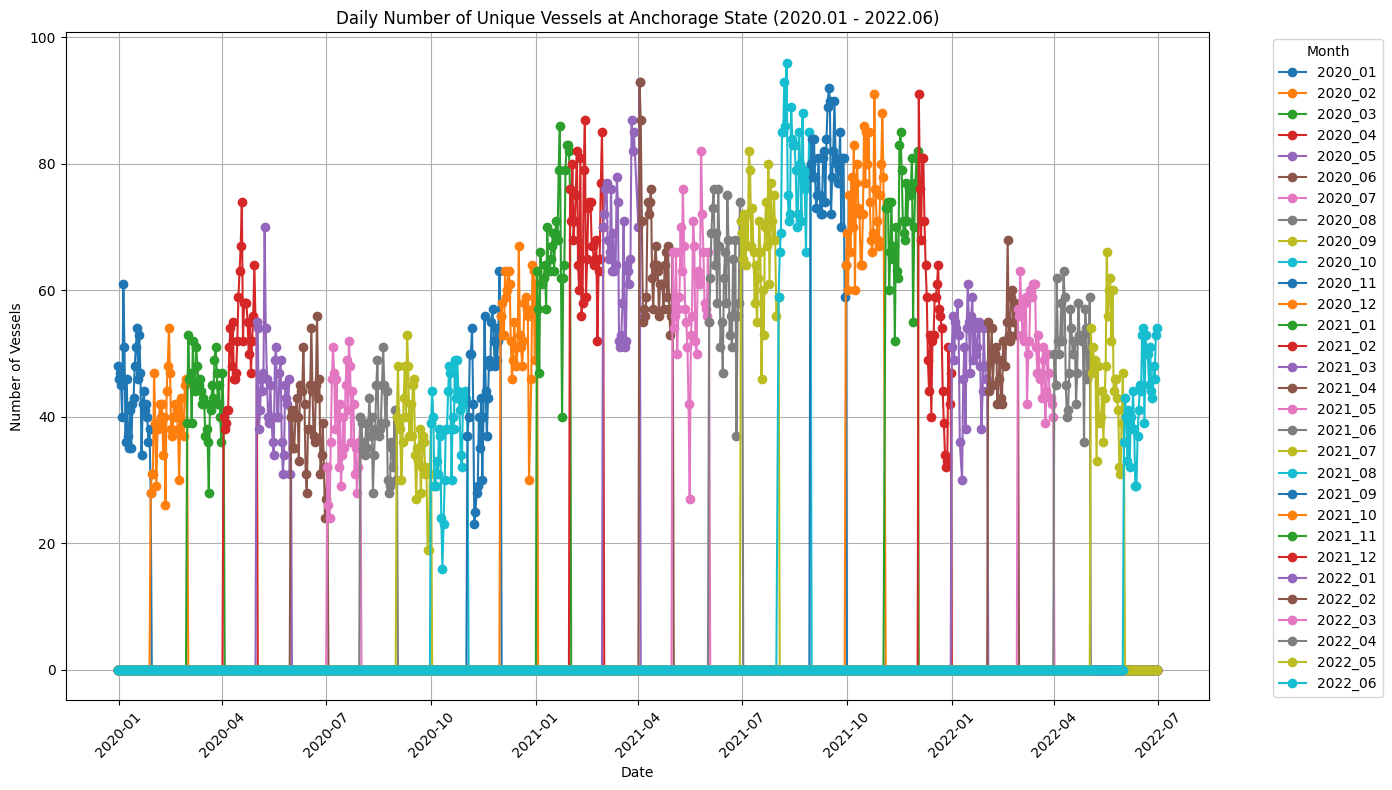

In [12]:

# Step 2: Plot combined results as a line chart
combined_daily_counts.plot(kind='line', figsize=(14, 8), marker='o')
plt.title('Daily Number of Unique Vessels at Anchorage State (2020.01 - 2022.06)')
plt.xlabel('Date')
plt.ylabel('Number of Vessels')
plt.xticks(rotation=45)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**saw some value=0, try to filer out**

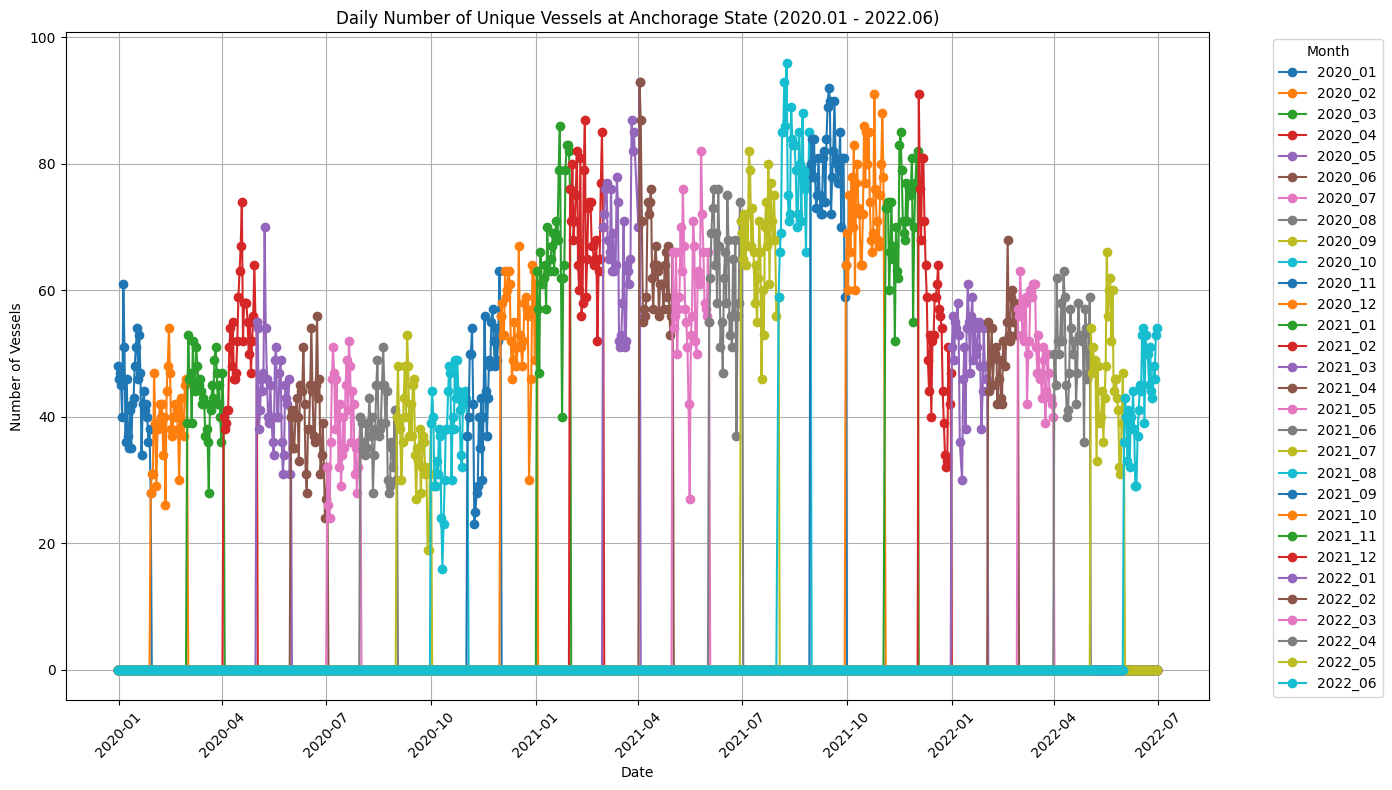

In [15]:
# Step 2: Remove rows where all values are zero
filtered_daily_counts = combined_daily_counts[(combined_daily_counts != 0).any(axis=1)]

# Step 3: Plot combined results as a line chart
filtered_daily_counts.plot(kind='line', figsize=(14, 8), marker='o')
plt.title('Daily Number of Unique Vessels at Anchorage State (2020.01 - 2022.06)')
plt.xlabel('Date')
plt.ylabel('Number of Vessels')
plt.xticks(rotation=45)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

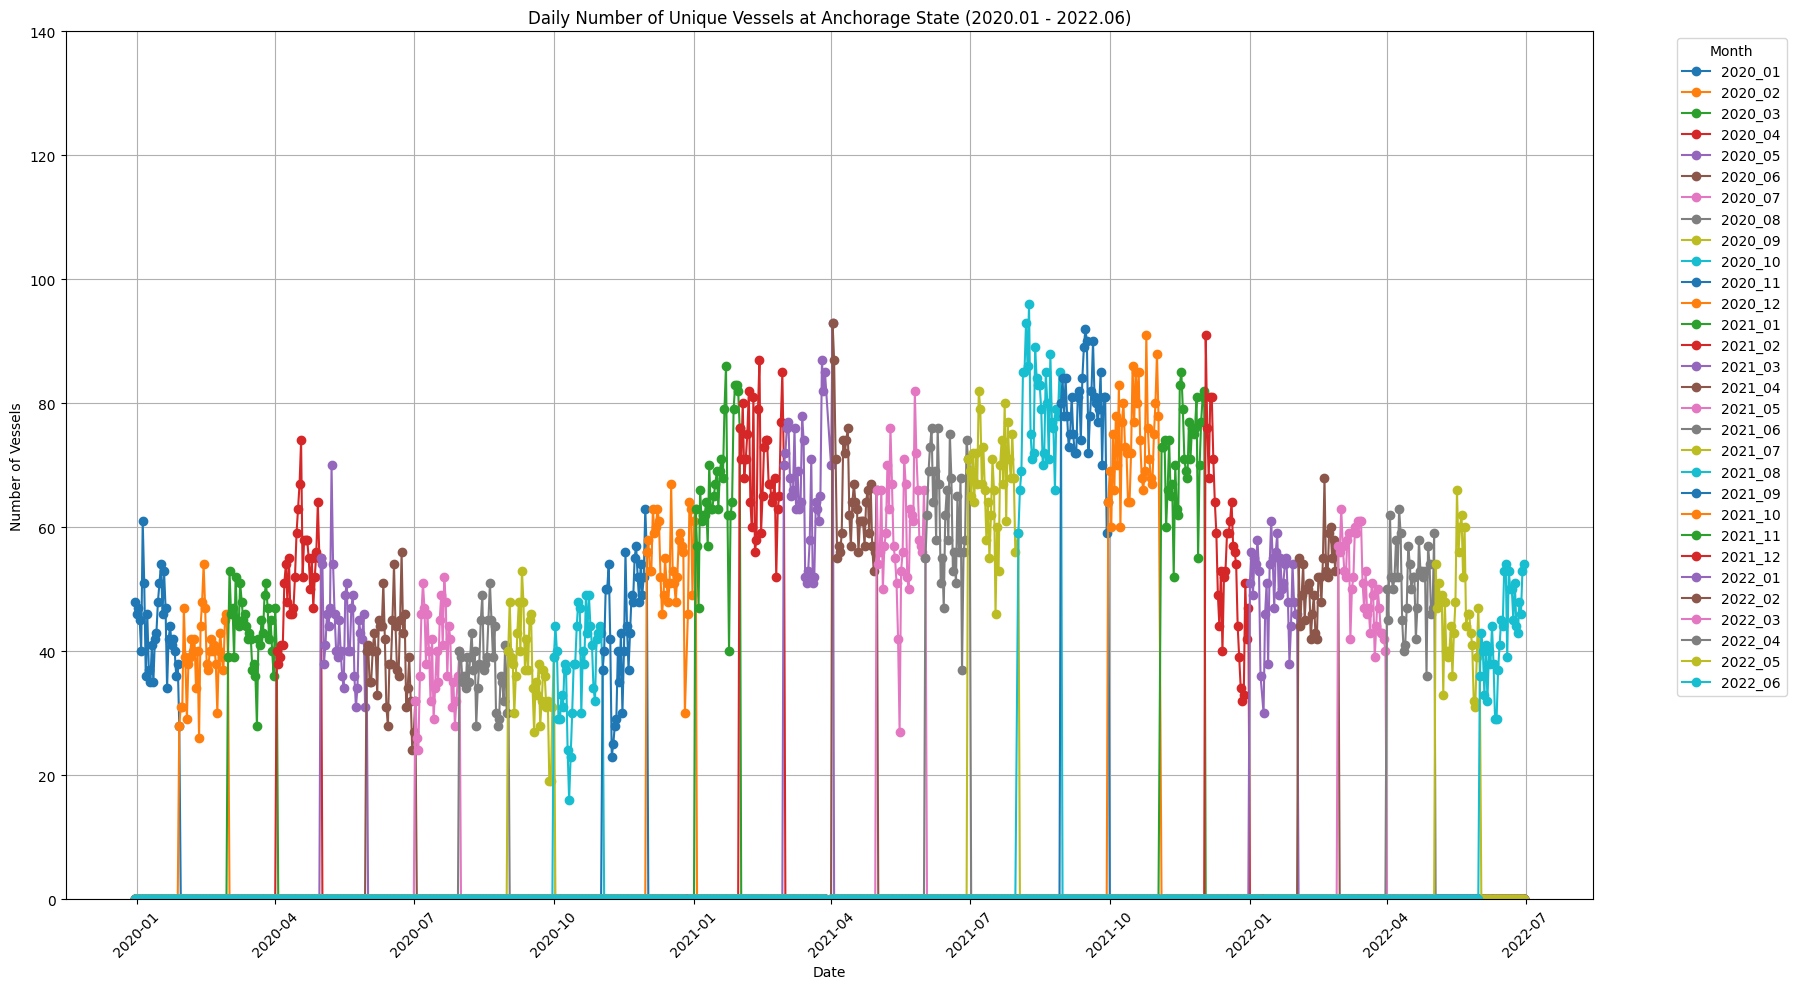

In [16]:
# Step 3: Plot combined results as a line chart
fig, ax = plt.subplots(figsize=(18, 10))  # Increase the figure size for better visibility
filtered_daily_counts.plot(kind='line', marker='o', ax=ax)
plt.title('Daily Number of Unique Vessels at Anchorage State (2020.01 - 2022.06)')
plt.xlabel('Date')
plt.ylabel('Number of Vessels')
plt.ylim(0, 140)  # Set Y-axis limit to 140
plt.xticks(rotation=45)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
